# Amazon Reviews Sentiment Analysis Using RNN,LSTM

**1-Importing important libraries**

In [12]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize

**2-Read Data**

In [13]:
df = pd.read_csv("../input/1429_1.csv")

In [14]:
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [15]:
df.info() #trying to understand all the column available in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
id                      34660 non-null object
name                    27900 non-null object
asins                   34658 non-null object
brand                   34660 non-null object
categories              34660 non-null object
keys                    34660 non-null object
manufacturer            34660 non-null object
reviews.date            34621 non-null object
reviews.dateAdded       24039 non-null object
reviews.dateSeen        34660 non-null object
reviews.didPurchase     1 non-null object
reviews.doRecommend     34066 non-null object
reviews.id              1 non-null float64
reviews.numHelpful      34131 non-null float64
reviews.rating          34627 non-null float64
reviews.sourceURLs      34660 non-null object
reviews.text            34659 non-null object
reviews.title           34655 non-null object
reviews.userCity        0 non-null float64
reviews.userProvince    0

From the columns presented what we are really interested in working with to complete the sentiment analysis would be the reviews.text and reviews.rating. 

In [16]:
data = df[["id","reviews.text","reviews.rating"]]
# the id has been chosen because under name there are more missing values. 
# from the description the ID represents a device sold by Amazon

In [17]:
data.head() 

,id,reviews.text,reviews.rating
0,AVqkIhwDv8e3D1O-lebb,This product so far has not disappointed. My c...,5.0
1,AVqkIhwDv8e3D1O-lebb,great for beginner or experienced person. Boug...,5.0
2,AVqkIhwDv8e3D1O-lebb,Inexpensive tablet for him to use and learn on...,5.0
3,AVqkIhwDv8e3D1O-lebb,I've had my Fire HD 8 two weeks now and I love...,4.0
4,AVqkIhwDv8e3D1O-lebb,I bought this for my grand daughter when she c...,5.0


In [18]:
data.describe(include=["O"])

,id,reviews.text
count,34660,34659
unique,42,34659
top,AVphgVaX1cnluZ0-DR74,Great features and easy to use. A must buy for...
freq,10966,1


We can see how there are a total of 42 products (from the ID). Meaning that for every product we will have a mix of reviews (positive, neutral or negative).

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 3 columns):
id                34660 non-null object
reviews.text      34659 non-null object
reviews.rating    34627 non-null float64
dtypes: float64(1), object(2)
memory usage: 812.4+ KB


We can see how one review.text is missing, hence no analysis can be done on this sample. We can then remove it. Furthermore, there are 32 missing values for the ratings. Due to the low number of missing values in the rating column it is possible to substitute the NaN with the mean of the others or we could simply remove those samples. Since we would have many samples anyway they can be simply removed.

In [20]:
data = data.dropna()

# Exploratory Data Analysis

We will start be veryfing what are the most common words used in the text reviews using a word cloud. However, since we haven't done the preprocessing before we might view some words that give little meaning to the sentiment of the text. 

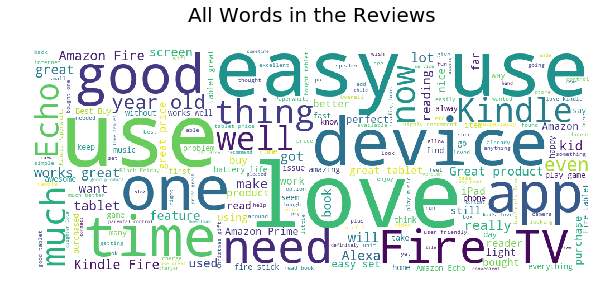

In [21]:
rt = data['reviews.text']
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(rt))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=20)
plt.axis('off')
plt.show()

As expected there are words that have have no importance with the sentiment of the comment, such as: use, device, time etc. 
Now I will perform a word count of certain words that could describe the sentiment in a better way.

In [22]:
words = ['awesome','great','fantastic','extraordinary','amazing','super',
                 'magnificent','stunning','impressive','wonderful','breathtaking',
                 'love','content','pleased','happy','glad','satisfied','lucky',
                 'shocking','cheerful','wow','sad','unhappy','horrible','regret',
                 'bad','terrible','annoyed','disappointed','upset','awful','hate']

rt = " ".join(data['reviews.text'])

In [23]:
diz = {}
for word in rt.split(" "):
    if word in words:
        diz[word] = diz.get(word,0)+1
        

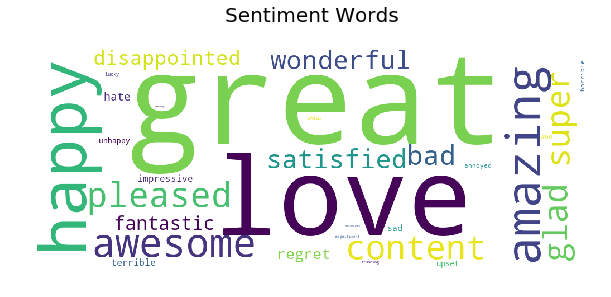

In [24]:
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate_from_frequencies(diz)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Sentiment Words\n',size=20)
plt.axis('off')
plt.show()

Most of the comments seem positive.
Now one thing that can be done is to view the average rating for every product. Unfortunately, the products are not well defined with a name due to the decision previously taken, but I will use the ID of the dataframe to represent the different products. 

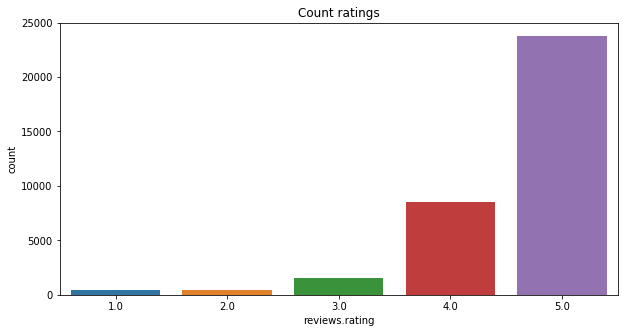

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(data['reviews.rating'])
plt.title('Count ratings')
plt.show()

In [26]:
data1 = data.groupby("id").mean().reset_index()

In [27]:
data1 = data1.sort_values(['reviews.rating']).reset_index()

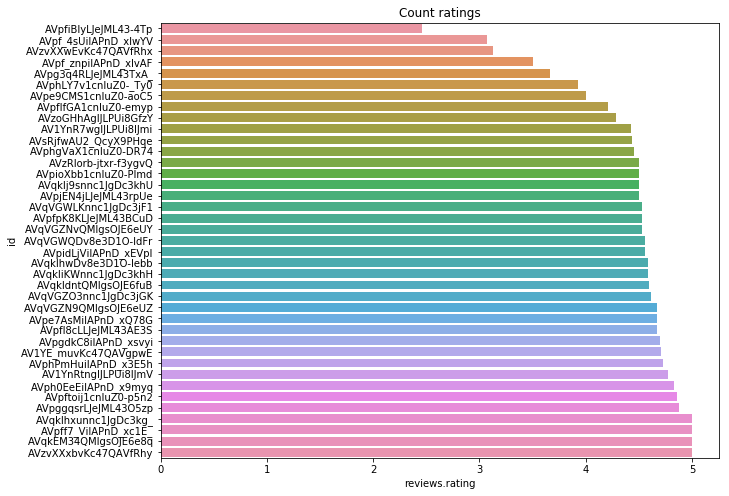

In [28]:
plt.figure(figsize=(10,8))
sns.barplot(x=data1["reviews.rating"], y=data1["id"])
plt.title('Count ratings')
plt.show()

We can clearly see how the reviews are heavily biased towards positive reviews. 4 and 5 ratings are extremely high and the averages are all above 3. To try and balance things out I will upload the other two csv files and get only the reviews that have ratings lower or equal to 3. So we are trying to oversample the lower rating reviews.

In [29]:
df2 = pd.read_csv("../input/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df3 = pd.read_csv("../input/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

In [30]:
data2 = df2[["id","reviews.text","reviews.rating"]]
data3 = df3[["id","reviews.text","reviews.rating"]]

In [31]:
data2 = data2[data2["reviews.rating"]<=3]
data3 = data3[data3["reviews.rating"]<=3]

In [32]:
len(data2), len(data3)

(2787, 314)

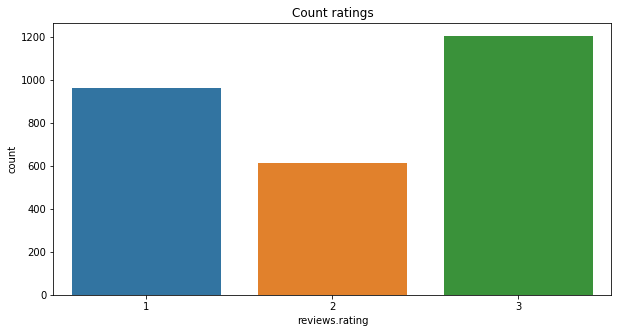

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(data2['reviews.rating'])
plt.title('Count ratings')
plt.show()

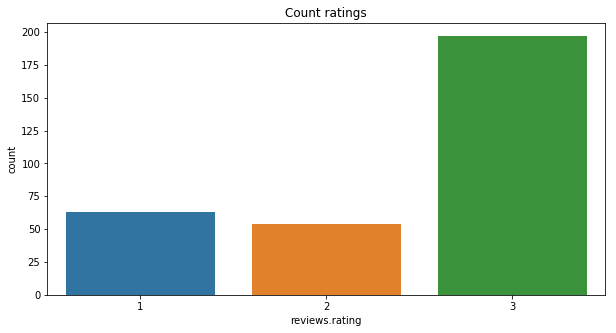

In [34]:
plt.figure(figsize=(10,5))
sns.countplot(data3['reviews.rating'])
plt.title('Count ratings')
plt.show()

Now that all three datasets are available I will concatenate them together.

In [35]:
frames = [data, data2, data3]
final = pd.concat(frames)

Verifying if the data is a little bit less biased

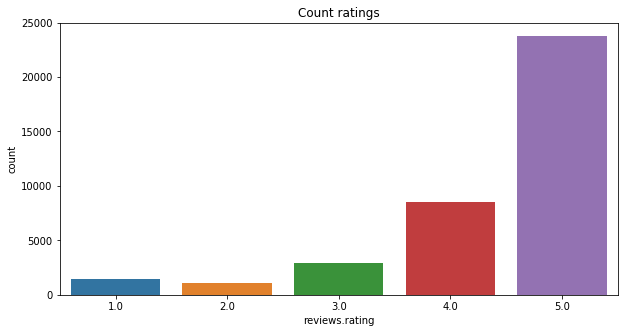

In [36]:
plt.figure(figsize=(10,5))
sns.countplot(final['reviews.rating'])
plt.title('Count ratings')
plt.show()

The situation hasn't improved a lot but hopefully it will make a difference when training the model later on. A further approach could be to undersample the positive reviews. 

In [37]:
final.head()

,id,reviews.text,reviews.rating
0,AVqkIhwDv8e3D1O-lebb,This product so far has not disappointed. My c...,5.0
1,AVqkIhwDv8e3D1O-lebb,great for beginner or experienced person. Boug...,5.0
2,AVqkIhwDv8e3D1O-lebb,Inexpensive tablet for him to use and learn on...,5.0
3,AVqkIhwDv8e3D1O-lebb,I've had my Fire HD 8 two weeks now and I love...,4.0
4,AVqkIhwDv8e3D1O-lebb,I bought this for my grand daughter when she c...,5.0


# Preprocessing Text

In [38]:
#lower case all text
final["reviews.text"]=final["reviews.text"].str.lower() 

#tokenization of words
final['reviews.text'] = final.apply(lambda row: word_tokenize(row['reviews.text']), axis=1) 

#only alphanumerical values
final["reviews.text"] = final['reviews.text'].apply(lambda x: [item for item in x if item.isalpha()]) 

#lemmatazing words
final['reviews.text'] = final['reviews.text'].apply(lambda x : [WordNetLemmatizer().lemmatize(y) for y in x])

#removing useless words
stop = stopwords.words('english')
final['reviews.text'] = final['reviews.text'].apply(lambda x: [item for item in x if item not in stop])


In [39]:
final["reviews.text"] = final["reviews.text"].apply(lambda x: str(' '.join(x))) #joining all tokens

In [40]:
final.head()

,id,reviews.text,reviews.rating
0,AVqkIhwDv8e3D1O-lebb,product far ha disappointed child love use lik...,5.0
1,AVqkIhwDv8e3D1O-lebb,great beginner experienced person bought gift ...,5.0
2,AVqkIhwDv8e3D1O-lebb,inexpensive tablet use learn step nabi wa thri...,5.0
3,AVqkIhwDv8e3D1O-lebb,fire hd two week love tablet great prime membe...,4.0
4,AVqkIhwDv8e3D1O-lebb,bought grand daughter come visit set user ente...,5.0


Since we are only provided with the ratings of the products we will try to assign a sentiment to all of the ratings. To do so we will consider a positive sentiment (1) when the ratings are 4 and 5. On the other hand, a negative sentiment (0) when the rating is 1,2 and 3. 

Eventually we will add an additional neutral sentiment.


In [41]:
sentiment = {1: 0,
            2: 0,
            3: 0,
            4: 1,
            5: 1}

final["sentiment"] = final["reviews.rating"].map(sentiment)

In [42]:
final.head()

,id,reviews.text,reviews.rating,sentiment
0,AVqkIhwDv8e3D1O-lebb,product far ha disappointed child love use lik...,5.0,1
1,AVqkIhwDv8e3D1O-lebb,great beginner experienced person bought gift ...,5.0,1
2,AVqkIhwDv8e3D1O-lebb,inexpensive tablet use learn step nabi wa thri...,5.0,1
3,AVqkIhwDv8e3D1O-lebb,fire hd two week love tablet great prime membe...,4.0,1
4,AVqkIhwDv8e3D1O-lebb,bought grand daughter come visit set user ente...,5.0,1


In [43]:
len(final[final["sentiment"]==0]),len(final[final["sentiment"]==1])

(5412, 32315)

We can see how the data is heavily biased to positive sentiments. One way to fix this would be to undersample the positive sentiments. Beofre doing this I would like to verify how the model will perform with these values.

In [44]:
# building tfidf matrix to train models 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer =TfidfVectorizer(max_df=0.9)
text = vectorizer.fit_transform(final["reviews.text"])

# Model Selection

In [45]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(text, final["sentiment"], test_size=0.3, random_state=1)



In [46]:
# try logistic regression first
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [47]:
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

Test accuracy 0.9112995847689725
Train accuracy 0.9300590730081794


Test and train accuracies are high, however, we must consider that the data is heavily biased towards positive reviews. Thus, the accuracies might not reflect if the model has learnt how to detect negative sentiments.

In [48]:
from sklearn.metrics import classification_report
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

Classification Report(Train)
              precision    recall  f1-score   support

           0       0.92      0.56      0.70      3769
           1       0.93      0.99      0.96     22639

    accuracy                           0.93     26408
   macro avg       0.92      0.78      0.83     26408
weighted avg       0.93      0.93      0.92     26408

Classification Report(Test)
              precision    recall  f1-score   support

           0       0.83      0.49      0.61      1643
           1       0.92      0.98      0.95      9676

    accuracy                           0.91     11319
   macro avg       0.88      0.73      0.78     11319
weighted avg       0.91      0.91      0.90     11319



By using the precision, recall and f1-score on every label we can verify how well the model has learnt to classify each label. The test and train scores are not that good for the negative reviews. We will try then to use another model, Random Forests.

They are extremely powerful for non linear data, furthermore they are extremely useful with unbalanced data sets. This is because they try to minimize the error rate. Lastly, they are less likely to overfitting as it is an ensemlbe algorithm.  

In [49]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)



/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [50]:
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

Test accuracy 0.9281738669493772
Train accuracy 0.9958345955770979


In [51]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

Classification Report(Train)
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3769
           1       1.00      1.00      1.00     22639

    accuracy                           1.00     26408
   macro avg       0.99      0.99      0.99     26408
weighted avg       1.00      1.00      1.00     26408

Classification Report(Test)
              precision    recall  f1-score   support

           0       0.84      0.62      0.72      1643
           1       0.94      0.98      0.96      9676

    accuracy                           0.93     11319
   macro avg       0.89      0.80      0.84     11319
weighted avg       0.92      0.93      0.92     11319



We can see an improvement in the precision, recall and f1 score for both classes. Even though the negative sentiment in the test data set has  a score of 0.71 for the f1 score, which is still an improvement from before

Let's try to improve this by using a 5-fold cross validation for parameter tuning.

In [52]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_estimators": [10,50,100,200],
             "criterion":("gini","entropy")}
classifier = RandomForestClassifier()
clf = GridSearchCV(classifier, parameters, cv=5)
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [53]:
#Viewing best parameters in Grid Search
best_parameter = clf.best_params_
best_accuracy = clf.best_score_ #best cros validated mean
print('Best parameter: ' + str(best_parameter))
print('Best accuracy: ' + str(best_accuracy))

Best parameter: {'criterion': 'entropy', 'n_estimators': 50}
Best accuracy: 0.935057558315662


In [54]:
classifier = RandomForestClassifier(criterion = best_parameter["criterion"], 
                                    n_estimators = best_parameter["n_estimators"])
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

Test accuracy 0.9354183231734252
Train accuracy 0.9994319903059679


In [55]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

Classification Report(Train)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3769
           1       1.00      1.00      1.00     22639

    accuracy                           1.00     26408
   macro avg       1.00      1.00      1.00     26408
weighted avg       1.00      1.00      1.00     26408

Classification Report(Test)
              precision    recall  f1-score   support

           0       0.91      0.61      0.73      1643
           1       0.94      0.99      0.96      9676

    accuracy                           0.94     11319
   macro avg       0.93      0.80      0.85     11319
weighted avg       0.93      0.94      0.93     11319



The overall performance has improved. We can see that the precision of the 0 label as increased, and so did the f1 score

We can say that the overall performance is satisfactory and we can proceed by trying to add a third label, the neutral sentiment value.


# 3 Labels
Trying with neutral, negative and positive

In [56]:
sentiment = {1: 0,
            2: 0,
            3: 1,
            4: 2,
            5: 2}

final["sentiment"] = final["reviews.rating"].map(sentiment)

In [57]:
final.head()

,id,reviews.text,reviews.rating,sentiment
0,AVqkIhwDv8e3D1O-lebb,product far ha disappointed child love use lik...,5.0,2
1,AVqkIhwDv8e3D1O-lebb,great beginner experienced person bought gift ...,5.0,2
2,AVqkIhwDv8e3D1O-lebb,inexpensive tablet use learn step nabi wa thri...,5.0,2
3,AVqkIhwDv8e3D1O-lebb,fire hd two week love tablet great prime membe...,4.0,2
4,AVqkIhwDv8e3D1O-lebb,bought grand daughter come visit set user ente...,5.0,2


In [58]:
len(final[final["sentiment"]==0]),len(final[final["sentiment"]==1]),len(final[final["sentiment"]==2])

(2510, 2902, 32315)

Again we can see how it is heavily biased towards the positive sentiment. 

In [59]:
# building tfidf matrix to train models 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer =TfidfVectorizer(max_df=0.9)
text = vectorizer.fit_transform(final["reviews.text"])

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(text, final["sentiment"], test_size=0.3, random_state=1)



In [61]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [62]:
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

Test accuracy 0.8931000971817298
Train accuracy 0.9096485913359588


In [63]:
from sklearn.metrics import classification_report
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

Classification Report(Train)
              precision    recall  f1-score   support

           0       0.85      0.60      0.70      1765
           1       0.79      0.21      0.33      2004
           2       0.92      1.00      0.95     22639

    accuracy                           0.91     26408
   macro avg       0.85      0.60      0.66     26408
weighted avg       0.90      0.91      0.89     26408

Classification Report(Test)
              precision    recall  f1-score   support

           0       0.75      0.49      0.59       745
           1       0.66      0.16      0.26       898
           2       0.90      0.99      0.95      9676

    accuracy                           0.89     11319
   macro avg       0.77      0.55      0.60     11319
weighted avg       0.88      0.89      0.87     11319



Very low F1 score for the test data set for the undersampled data sets. We'll try with the Randm Forest algorithm again.

In [64]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)



/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [65]:
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

Test accuracy 0.9199575934269811
Train accuracy 0.994887912753711


In [66]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

Classification Report(Train)
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1765
           1       0.99      0.96      0.98      2004
           2       1.00      1.00      1.00     22639

    accuracy                           0.99     26408
   macro avg       0.99      0.98      0.99     26408
weighted avg       0.99      0.99      0.99     26408

Classification Report(Test)
              precision    recall  f1-score   support

           0       0.80      0.61      0.70       745
           1       0.78      0.45      0.57       898
           2       0.93      0.99      0.96      9676

    accuracy                           0.92     11319
   macro avg       0.84      0.68      0.74     11319
weighted avg       0.91      0.92      0.91     11319



There is a slight improvement with the random forest compared to the logit model. Let's try increasing the scores by using the grid search one more time and tune the parameters. 

In [67]:
parameters = {"n_estimators": [10,50,100,200],
             "criterion":("gini","entropy")}
classifier = RandomForestClassifier()
clf = GridSearchCV(classifier, parameters, cv=5)
clf.fit(x_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [68]:
#Viewing best parameters in Grid Search
best_parameter = clf.best_params_
best_accuracy = clf.best_score_ #best cros validated mean
print('Best parameter: ' + str(best_parameter))
print('Best accuracy: ' + str(best_accuracy))

Best parameter: {'criterion': 'entropy', 'n_estimators': 100}
Best accuracy: 0.9230536201151166


In [69]:
classifier = RandomForestClassifier(criterion = best_parameter["criterion"] , 
                                    n_estimators = best_parameter["n_estimators"])
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)

In [70]:
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

Test accuracy 0.9251700680272109
Train accuracy 0.9988639806119358


In [71]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

Classification Report(Train)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1765
           1       1.00      0.99      0.99      2004
           2       1.00      1.00      1.00     22639

    accuracy                           1.00     26408
   macro avg       1.00      1.00      1.00     26408
weighted avg       1.00      1.00      1.00     26408

Classification Report(Test)
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       745
           1       0.89      0.42      0.57       898
           2       0.93      1.00      0.96      9676

    accuracy                           0.93     11319
   macro avg       0.89      0.68      0.75     11319
weighted avg       0.92      0.93      0.91     11319



We can observe a small improvement in the different scores.

# Conclusions

From the models evaluated we can say that the three label sentiment analysis provieds good enough results. However, it can be improved by balancing the dataset. Either increasing the number of negative and neutral labels or by decreasing the positive labels. The f1, precision and recall overall score of the latest Random Forest model has good results. 

# RNN

Sentiment analysis can obtain wonderful results using RNN.


In [72]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [73]:
t = Tokenizer()

In [74]:
t.fit_on_texts(final["reviews.text"])

In [75]:
max_length = max([len(s.split()) for s in final["reviews.text"] ])
max_legth=max_length #the max length is aroun 1000 character. I would keep it shorter. 

In [76]:
vocab_size = len(t.word_index)+1

In [77]:
X_train, X_test, y_train, y_test = train_test_split(final["reviews.text"], final["sentiment"], test_size=0.25)


In [78]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

In [79]:
X_train = pad_sequences(X_train, maxlen=max_length, padding = "post",truncating = "post")
X_test = pad_sequences(X_test, maxlen=max_length, padding = "post", truncating = "post")

In [80]:
X_train = X_train[0:28290]
y_train = y_train[0:28290]
X_test = X_test[0:9430]
y_test = y_test[0:9430]
len(y_test),len(X_test),len(X_train),len(y_train)

(9430, 9430, 28290, 28290)

In [81]:
from keras.utils import np_utils #converting to categorical
y_train = np_utils.to_categorical(y_train, num_classes=3)
y_test = np_utils.to_categorical(y_test, num_classes=3)

In [82]:
embedding_dim = 200
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(units = 32))
model.add(Dense(3,activation="softmax")) #since converted to categorical we will have three output nodes. softmax
                                         # assigns a probability distribution
    
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=10, epochs=3)

Epoch 1/3
28290/28290 [==============================] - 2594s 92ms/step - loss: 0.3126 - acc: 0.9029
Epoch 2/3
28290/28290 [==============================] - 2591s 92ms/step - loss: 0.3109 - acc: 0.9039
Epoch 3/3
28290/28290 [==============================] - 2540s 90ms/step - loss: 0.3105 - acc: 0.9039


In [83]:
model.evaluate(x=X_test, y=y_test, batch_size=10)


9430/9430 [==============================] - 139s 15ms/step


[0.307264793960502, 0.9058324696529708]